<a href="https://colab.research.google.com/github/ssoad/PyTorch-ImageSegementation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 1.7 MB/s 
     |████████████████████████████████| 376 kB 60.2 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9bda95a9483bc84771bae52984b308169974bbd6149198a0f2be61aaa419c368
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4c4a376d44823a933eee9bbe853097f4c86f96f77e2f3db0652d094b2511fee8
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


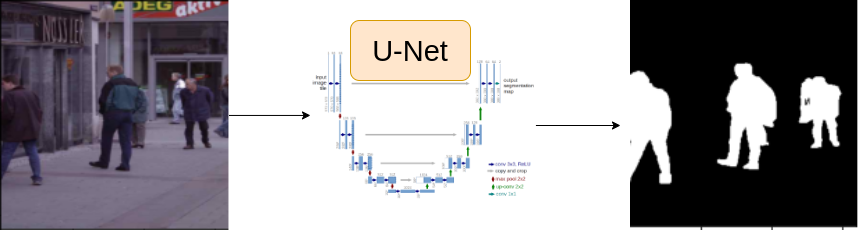

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

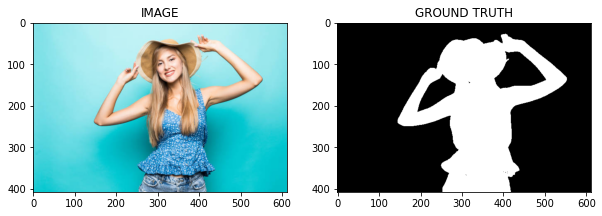

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df, augmentations):
    self.df=df
    self.augmentations = augmentations 
  def __len__(self):
    return len(self.df)
  def __getitem__(self ,idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask =np.expand_dims(mask ,axis=-1)

    if self.augmentations :
      data =self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data ['mask']

    #(h,w,c) -> (c,h,w)
    image = np.transpose(image ,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask ,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [14]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


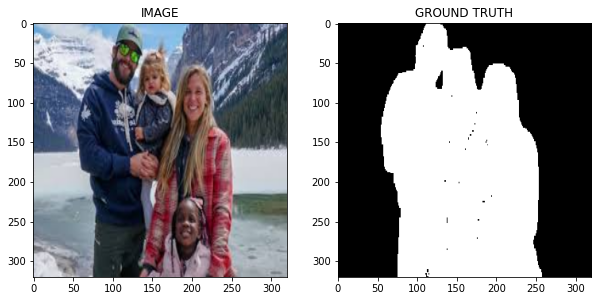

In [16]:
idx = 2
image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader


In [18]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [19]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")

total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [20]:
for image , mask in trainloader:
  break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch image shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [24]:
class SegmentationModel (nn.Module):

  def __init__(self):
    super (SegmentationModel , self).__init__()
    
    self.arc = smp.Unet(
        encoder_name= ENCODER ,
        encoder_weights=  WEIGHTS ,
        in_channels= 3 ,
        classes=  1 ,
        activation = None
    )
  def forward (self ,images ,masks = None):
    logits = self.arc(images)
    
    if masks != None :
      loss1 = DiceLoss(mode='binary')(logits , masks)
      loss2 = nn.BCEWithLogitsLoss()(logits , masks)
      return logits , loss1+loss2
    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [27]:
def train_fn (data_loader , model , optimizer):
  model.train()
  total_loss =0.0

  for images, masks in tqdm(data_loader) :

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits , loss = model(images ,masks)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()

    return total_loss / len(data_loader)

In [28]:
def eval_fn (data_loader , model ):

  model.eval()
  total_loss =0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader) :

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits , loss = model(images ,masks)

      total_loss +=loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [30]:
optimizer = torch.optim.Adam(model.parameters(),lr= LR)

In [36]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader , model , optimizer)
  valid_loss = eval_fn(validloader , model  )

  if valid_loss< best_valid_loss :
    torch.save(model.state_dict(), 'bestModel.pt')
    print ("SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}" )

100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED
Epoch : 1 train_loss :0.025479980309804282 valid_loss :0.4171292185783386


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED
Epoch : 2 train_loss :0.018484008312225342 valid_loss :0.3909417577087879


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 3 train_loss :0.02090799609820048 valid_loss :0.41798555850982666


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 4 train_loss :0.0240361750125885 valid_loss :0.4855945557355881


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 5 train_loss :0.01968621015548706 valid_loss :0.4355405457317829


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 6 train_loss :0.020374683539072673 valid_loss :0.420598890632391


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED
Epoch : 7 train_loss :0.017131535212198894 valid_loss :0.3635583855211735


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED
Epoch : 8 train_loss :0.01566116710503896 valid_loss :0.3164372332394123


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 9 train_loss :0.01358203887939453 valid_loss :0.32799750566482544


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 10 train_loss :0.029054691394170124 valid_loss :0.3293153867125511


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 11 train_loss :0.021970669428507488 valid_loss :0.3399127274751663


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 12 train_loss :0.02348660628000895 valid_loss :0.36672861501574516


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 13 train_loss :0.015723461906115215 valid_loss :0.41584349423646927


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 14 train_loss :0.0206994891166687 valid_loss :0.38873978704214096


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 15 train_loss :0.02250783642133077 valid_loss :0.35036880522966385


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 16 train_loss :0.014520998795827229 valid_loss :0.34683624282479286


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 17 train_loss :0.01776446501413981 valid_loss :0.3632761910557747


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 18 train_loss :0.016094624002774557 valid_loss :0.38963583111763


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 19 train_loss :0.019939144452412922 valid_loss :0.40922560170292854


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 20 train_loss :0.025710825125376383 valid_loss :0.3910186253488064


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch : 21 train_loss :0.020417094230651855 valid_loss :0.35690612345933914


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


SAVED
Epoch : 22 train_loss :0.021014581123987835 valid_loss :0.31081920862197876


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


SAVED
Epoch : 23 train_loss :0.018418689568837483 valid_loss :0.2966581881046295


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch : 24 train_loss :0.019961053133010866 valid_loss :0.31423384323716164


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

Epoch : 25 train_loss :0.015635807315508524 valid_loss :0.34220027923583984


# Task 9 : Inference

In [39]:
idx = 10
model.load_state_dict(torch. load('/content/bestModel.pt'))
image, mask = validset[idx]
logits_mask = model (image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid (logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

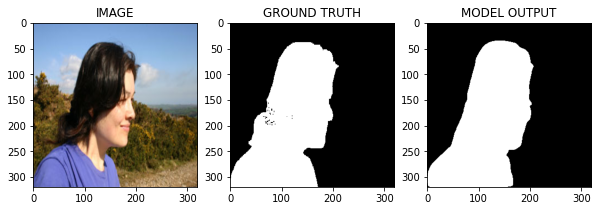

In [38]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya